# Quantum Fourier transform

In this tutorial, we will learn how to write and execute a quantum Fourier transform.

Warning: the bit ordering is not the same in input and output conventions. The relation between the input and output amplitudes is

$$\tilde{a}_{x}=\frac{1}{\sqrt{2^{n}}}\sum_{k=0}^{2^{n}}
\left(e^{\frac{2i\pi}{2^{n}}}\right)^{xk}a_{k}$$

with $|\psi_{\mathrm{in}}\rangle=\sum_{k=0}^{2^{n}-1}a_{k}|k\rangle$, $|\psi_{\mathrm{out}}\rangle
=\sum_{x=0}^{2^{n}-1}\tilde{a}_{x}|x\rangle$, and 

$|k\rangle=|b_{0}^{(k)},\dots b_{n-1}^{(k)}\rangle$ and $|x\rangle=
|b_{n-1}^{(x)},\dots,b_{0}^{(x)}\rangle$ (note the reversed bit order).


The pseudo-code for the Quantum Fourier transform is:

    let n denote the number of qubits
    for i in 0 .. n-1:
        apply H on qubit i
        for j in i+1 .. n-1
            angle = 2*pi/(2^{j-i+1})
            apply a control-PH(angle) gate on qubits j (control qubit) and i (target qubit) 


## QLM implementation

We can first use the QFT routine that is already implemented in ``myQLM``:

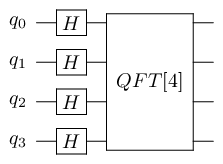

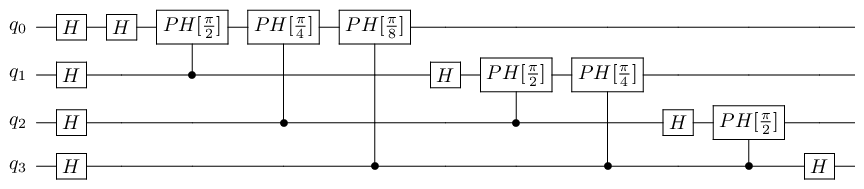

|0000> 0.9999999999999987


In [1]:
from qat.lang.AQASM.qftarith import QFT
from qat.lang.AQASM import Program, H
from qat.qpus import get_default_qpu

nqbits = 4

prog = Program()
reg = prog.qalloc(nqbits)
# here, we initialize the register with a superposition state (we could have chosen another initialization)
for qb in range(nqbits):
    H(reg[qb]) # equivalent to prog.apply(H, reg[qb])
    
prog.apply(QFT(nqbits), reg)

circ = prog.to_circ()

%qatdisplay circ

# we can expand the "QFT box":
%qatdisplay circ --depth 2

# let us execute it on a QPU
qpu = get_default_qpu()
job = circ.to_job(nbshots=0)
res = qpu.submit(job)

for sample in res:
    print(sample.state, sample.probability)

- Is it the result you expected?
- What happens if you change the initialization?

## Our own implementation

Let us now write our own implementation.

In [2]:
import numpy as np
from qat.lang.AQASM import QRoutine, PH

def myQFT(nqbits):
    routine = QRoutine()
    for qb1 in range(nqbits):
        routine.apply(H, qb1)
        for qb2 in range(qb1 + 1, nqbits):
            angle = 2 * np.pi / 2**(qb2 - qb1 + 1)
            routine.apply(PH(angle).ctrl(), qb2, qb1)
    return routine

We can test it inside a program where we initialize the qubit register with a wall of Hadamard gates (aka Hadamard-Walsh transform):

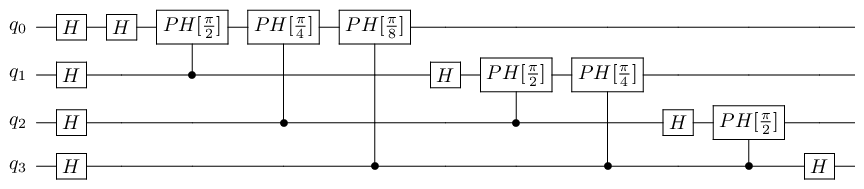

|0000> 0.9999999999999987


In [3]:
nqbits=4
prog = Program()
reg = prog.qalloc(nqbits)
for qb in range(nqbits):
    H(reg[qb])
prog.apply(myQFT(nqbits), reg)

circ = prog.to_circ()

%qatdisplay circ

qpu = get_default_qpu()
job = circ.to_job(nbshots=0)
res = qpu.submit(job)

for sample in res:
    print(sample.state, sample.probability)

## Quantum Fourier Transformation of a signal

To go further, we now look into the hypothetical case where we have encoded a signal in the quantum register, and want to perform its Fourier transform.

Such an encoding for an arbitrary signal is by no means simple. It in principle requires a so-called quantum random access memory (QRAM). Such QRAMs do not exist yet. One must also bear in mind that to load a classical signal of size $2^n$ in a QRAM, one needs $n$ qubits (hence an exponentialy memory gain compared to a classical storage), but one a priori needs $O(2^n)$ steps to perform this loading into the QRAM. 

In the following, we will nevertheless assume we have loaded such a signal. We will see later (see lecture on Shor's algorithm) that this loading problem can be avoided by solving problems where such an exponentially-large data input is not needed.

In [4]:
def prepare_signal(nqbits):
    """Prepare a normalized input signal for the FT
    Here, we choose a signal with two frequency components: om and 3*om
    """
    t_max = 100
    times = np.linspace(0, t_max, 2**nqbits)
    om = 0.5
    f = lambda t: 4 * np.exp(-1j * t * om) + 1 * np.exp(-1j * 3 * t * om)  
    signal = np.array([f(t) for t in times])
    return signal / np.linalg.norm(signal)

We can check that this signal does have two harmonics:

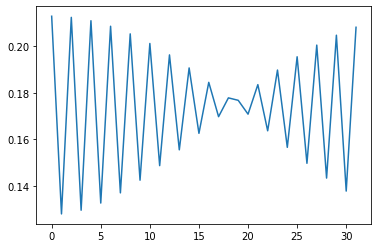

In [5]:
import matplotlib.pyplot as plt
nqbits = 5
signal = prepare_signal(nqbits)
plt.plot(abs(signal))

### Check

We first check that the state preparation routine does its job.

In [6]:
use_qpu = "pylinalg"

if use_qpu == "pylinalg":
    from qat.qpus import PyLinalg
    from qat.lang.AQASM import AbstractGate
    StatePreparation = AbstractGate("STATE_PREPARATION", [np.ndarray])
    qpu = PyLinalg()
else:
    from qat.linalg.oracles import StatePreparation
    from qat.qpus import LinAlg
    qpu = LinAlg()

prog = Program()
reg = prog.qalloc(nqbits)
prog.apply(StatePreparation(signal), reg)
circ = prog.to_circ()
res = qpu.submit(circ.to_job())
probs = np.zeros(2**nqbits)
for sample in res:
    probs[sample.state.int] = sample.probability

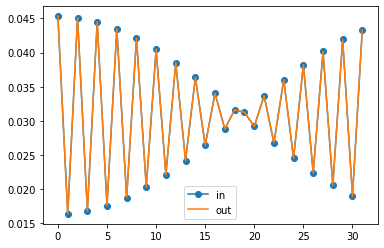

In [7]:
plt.plot(abs(signal)**2, '-o', label="in")
plt.plot(probs, label="out")
plt.legend()

### Application of the QFT routine

We now build a program that applies a QFT to the register:

In [8]:
from qat.lang.AQASM import QInt
nqbits = 5
prog = Program()
reg = prog.qalloc(nqbits, class_type=QInt, reverse_bit_order=True)
prog.apply(StatePreparation(signal), reg)
prog.apply(QFT(nqbits), reg)
circ = prog.to_circ()

res = qpu.submit(circ.to_job())
probs = np.zeros(2**nqbits)
for sample in res:
    probs[sample.state.value] = sample.probability

We reversed the bit order because bit ordering convention of the output register of the QFT is unconventional.

We can check that we do have the two harmonics:

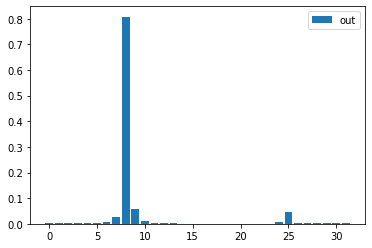

In [9]:
plt.bar(np.array(range(2**nqbits)),
        probs,
        width=4/5, label="out")
plt.legend()

Let us compare to the result of a classical (I)FFT. Here, we directly compare probability amplitudes.

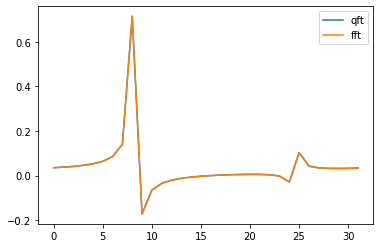

In [10]:
amps = np.zeros(2**nqbits, np.complex_)
for sample in res:
    amps[sample.state.value] = sample.amplitude
plt.plot(amps, label = "qft")
fft_signal = np.fft.ifft(signal) * np.sqrt(2**nqbits) # the 2**nqbits factor comes from a slightly different normalization
plt.plot(fft_signal, label = "fft")
plt.legend()

### Noisy simulation

We now use a noisy QPU with depolarizing noise and investigate the impact of such a noise on the output spectrum.

In [11]:
from depolarizing_plugin import DepolarizingPlugin
depol_plugin = DepolarizingPlugin(prob_1qb=0.005, prob_2qb=0.05)
noisy_qpu = depol_plugin | qpu

res = noisy_qpu.submit(circ.to_job())
noisy_probs = np.zeros(2**nqbits)
for sample in res:
    noisy_probs[sample.state.value] = sample.probability

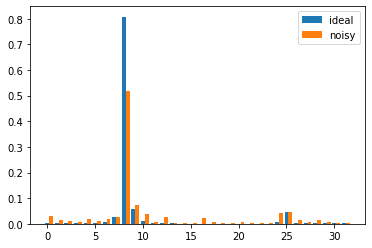

In [12]:
plt.bar(np.array(range(2**nqbits)),
        probs,
        width=2/5, label="ideal")
plt.bar(np.array(range(2**nqbits))+2/5,
        noisy_probs,
        width=2/5, label="noisy")
plt.legend()

An important caveat of this study is that reading out the output signal is also potentially an exponentially long task: if the support of the spectrum is exponentially large, in order to recover a proper estimate of the spectrum, we will need exponentially many measurements.

To avoid this overhead, quantum algorithm designers use QFTs as a subroutine for problems where the final spectrum is known to be sparse, in which case it can be recovered in a few shots. This is for instance what is achieved in Shor's algorithm.